In [1]:
import astra
import numpy as np
import scipy.io as sio
import os
import tifffile

In [2]:
# Geometry details: number of projections, size of dataset, and amount of noise
na = 64
nd = 256
ns = 128
i0 = 10**3

In [3]:
# Create ASTRA geometries
vol_geom = astra.create_vol_geom(nd,nd)
proj_geom = astra.create_proj_geom('parallel',1.0,nd,np.linspace(0,np.pi,na,False))

# Create the ASTRA projector
pid = astra.create_projector('linear',proj_geom,vol_geom) # change 'linear' to 'cuda' to use GPU
p = astra.OpTomo(pid)

# Create simulated HQ dataset for training
hq = np.zeros((ns,nd,nd))
hq[:,nd//4:3*nd//4,nd//4:3*nd//4]=1
hq[:,3*nd//8:5*nd//8,3*nd//8:5*nd//8]=0

In [4]:
try:
    os.mkdir('hqrecs/')
except OSError:
    pass
projections = np.zeros((ns, na, nd))
for i in range(ns):
    projections[i] = astra.add_noise_to_sino((p*hq[i]).reshape(p.sshape),i0)
    tifffile.imsave('hqrecs/{:04d}.tiff'.format(i),hq[i])

In [5]:
try:
    os.mkdir('trainfiles/')
except OSError:
    pass
for i in range(ns):
    p.reconstruct('BP',
                  projections[i],
                  extraOptions={'hqrecfiles':'hqrecs/*.tiff',
                                'z_id':i})

In [6]:
# Generate test sinogram
testSino = astra.add_noise_to_sino((p*hq[ns//2]).reshape(p.sshape),i0)
if astra.projector.is_cuda(pid):
    fbpRec = p.reconstruct('FBP_CUDA',testSino)
    sirtRec = p.reconstruct('SIRT_CUDA',testSino,1000)
else:
    fbpRec = p.reconstruct('FBP',testSino)
    sirtRec = p.reconstruct('SIRT',testSino,1000)

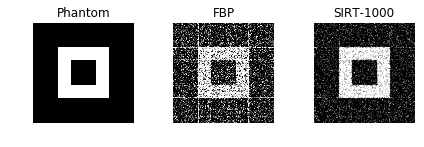

In [7]:
# Show the different reconstructions on screen
%matplotlib inline
import pylab
pylab.gray()
pylab.subplot(131)
pylab.axis('off')
pylab.title('Phantom')
pylab.imshow(hq[ns//2],vmin=0,vmax=1)
pylab.subplot(132)
pylab.axis('off')
pylab.title('FBP')
pylab.imshow(fbpRec,vmin=0,vmax=1)
pylab.subplot(133)
pylab.axis('off')
pylab.title('SIRT-1000')
pylab.imshow(sirtRec,vmin=0,vmax=1)
pylab.tight_layout()
pylab.show()